# Import Packages

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, average_precision_score, make_scorer, precision_recall_curve, roc_curve, mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.linear_model import LogisticRegression
plt.style.use('ggplot')

# Load Data

In [3]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()
segments = pd.read_csv("../customer_segmentation/segments.csv", index_col=0)

# Setup Model

In [4]:
nulls = [col for col, val in df.isnull().any().to_dict().items() if val == True]
print(nulls)

[]


In [5]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 5

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if set(df[column].unique()) == {0, 1}:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

categorical_features = [col for col in categorical_features if col != "nr_years"] + ['last_product']
continuous_features = [col for col in continuous_features if col != "last_product"] + ['nr_years']

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')

for col in categorical_features:
     df[col] = df[col].astype("category")

for col in binary_features:
     df[col] = df[col].astype("int")

for col in continuous_features:
     df[col] = df[col].astype("float")

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'lpa']
Categorical Features: ['policy_nr_hashed', 'count', 'last_data_year', 'first_datapoint_year', 'last_datapoint_year', 'control_group', 'last_brand', 'last_type', 'last_fuel_type', 'last_product', 'last_sales_channel', 'nr_cars', 'n_last_vs_peak', 'last_product']
Continuous Features: ['welcome_discount', 'first_data_year', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'last_postcode', 'max_nr_coverages', 'last_nr_coverages', 'accident_years', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc', 'pc4', 'nr_years', 'nr_ppl', 'males', 'females', 'tot_15y', '15_tot_25y', '25_tot_45y', '4_tot_65y', '65y_plus', 'perc_nld_ppl', 'perc_western_ppl', 'perc_others_ppl', 'nr_households', 'household_size', 'nr_

In [6]:
# cols_to_drop_manual = ["first_split", "first_premium", "nr_cars", "last_type", "last_brand", 'last_weight', 'n_last_vs_peak', 'last_fuel_type', 'last_trend_nr_coverages', 'last_change_premium_abs', 'last_change_premium_perc', 'max_nr_coverages', 'last_nr_coverages',]
cols_to_drop = ["churn", "policy_nr_hashed", "last_data_year", "first_data_year", "welcome_discount", "control_group", 'count', 'first_datapoint_year', 'last_datapoint_year']
selected_columns = [col for col in df.columns if not any(col.startswith(prefix) for prefix in cols_to_drop)]

X = df[selected_columns]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Custom Metric

In [7]:
# weights = {
#     'TP': 0,  # High importance to correctly identify churners
#     'FP': 0,  # Moderate to high cost of misclassifying loyal customers
#     'FN': 100.0,   # High cost of missing actual churners
#     'TN': 100.0
# }

# def weighted_cost(y_true, y_scores, weights):

#     tn, fp, fn, tp = confusion_matrix(y_true, y_scores).ravel()

#     # Weight everyone
#     TP_wght = tp * weights['TP']
#     FP_wght = fp * weights['FP']
#     FN_wght = fn * weights['FN']
#     TN_wght = tn * weights['TN']

#     # Compute weighted cost and normalise
#     wghtd_cost = TP_wght + FP_wght + FN_wght + TN_wght

#     return -wghtd_cost

# weighted_cost_scorer = make_scorer(weighted_cost, needs_proba=True, weights=weights)

# Model Selection

In [8]:
space = {
    'max_depth': hp.uniformint('max_depth', 50, 100),
    'n_estimators': hp.uniformint('n_estimators', 50, 200),
    'num_leaves': hp.uniformint('num_leaves', 2, 200),
    'min_child_samples': hp.uniformint('min_child_samples', 7, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.25, 1),
    'subsample': hp.uniform('subsample', 0.25, 1),
    'subsample_freq': hp.uniformint('subsample_freq', 1, 100),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 1, 21),
}

def objective(params):
    clf = lgb.LGBMClassifier(
        objective='binary',
        force_row_wise=True,
        verbosity=-1,
        # n_estimators=50,
        **params
    )
    score = cross_val_score(clf, X_train[X_train["welcome_discount"] == 0], y_train, cv=5, scoring="neg_brier_score").mean()
    return {'loss': -score, 'status': STATUS_OK}

n_iter = 50
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iter, trials=trials)

print("Best Score is: ", -trials.best_trial['result']['loss'])
print("Best Parameters: ", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: 'welcome_discount'



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


KeyError: 'welcome_discount'

In [9]:
best = {'colsample_bytree': 0.8415229383909493, 'learning_rate': 0.023375272621823318, 'max_depth': 73.0, 'min_child_samples': 49.0, 'min_data_in_leaf': 6.0, 'min_split_gain': 0.3349142609935463, 'n_estimators': 164.0, 'num_leaves': 180.0, 'reg_alpha': 0.07871752728134146, 'reg_lambda': 0.047610247070413274, 'subsample': 0.743174247931145, 'subsample_freq': 21.0}

best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'num_leaves': int(best['num_leaves']),
    'min_child_samples': int(best['min_child_samples']),
    'colsample_bytree': best['colsample_bytree'],
    'subsample': best['subsample'],
    'subsample_freq': int(best['subsample_freq']),
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain'],
    'learning_rate': best['learning_rate'],
    'min_data_in_leaf': int(best['min_data_in_leaf'])
}

lgbm_best = lgb.LGBMClassifier(
    objective='binary',
    force_row_wise=True,
    verbosity=-1,
    **best_params
)

# Validation

In [ ]:
def mae_prob(y_true, y_pred_probs):
    return mean_absolute_error(y_true, y_pred_probs)

def medae_prob(y_true, y_pred_probs):
    return median_absolute_error(y_true, y_pred_probs)

mae_prob_scorer = make_scorer(mae_prob, needs_proba=True)
medae_prob_scorer = make_scorer(medae_prob, needs_proba=True)

In [ ]:
scores_brier = cross_val_score(lgbm_best, X, y, cv=5, scoring='neg_brier_score')
scores_log_loss = cross_val_score(lgbm_best, X, y, cv=5, scoring='neg_log_loss')
scores_mae = cross_val_score(lgbm_best, X, y, cv=5, scoring=mae_prob_scorer)
scores_medae = cross_val_score(lgbm_best, X, y, cv=5, scoring=medae_prob_scorer)

print('CV Average Brier score: {0:0.4f}'.format(-np.mean(scores_brier)))
print('CV Average Log Loss: {0:0.4f}'.format(-np.mean(scores_log_loss)))
print('CV Average Root Brier score: {0:0.4f}'.format(np.sqrt(-np.mean(scores_brier))))
print('CV MAE: {0:0.4f}'.format(np.mean(scores_mae)))
print('CV MedAE: {0:0.4f}'.format(np.mean(scores_medae)))

CV Average Brier score: 0.1014
CV Average Log Loss: 0.3451
CV Average Root Brier score: 0.3185
CV MAE: 0.2011
CV MedAE: 0.0962


# Actually Running

In [10]:
df_filt = df[df["welcome_discount"] == 0]

X = df_filt[selected_columns]
y = df_filt['churn']

lgbm_best.fit(X, y)
predictions = lgbm_best.predict_proba(df[selected_columns])

In [15]:
predictions_np = np.array([i[1] for i in predictions])
df['proba'] = predictions_np

predictions_final = df.merge(segments, how="inner", on="policy_nr_hashed")

predictions_final = predictions_final[predictions_final["welcome_discount"] > 0]
# predictions_final = predictions_final[predictions_final["welcome_discount"] <= 0.3]

display(predictions_final.groupby("cluster").agg({"proba": "mean", "churn": "mean", "welcome_discount": "mean"}))

,proba,churn,welcome_discount
cluster,,,
0,0.174752,0.233894,0.195716
1,0.152048,0.241103,0.188435
2,0.226588,0.259680,0.183578
3,0.145397,0.236354,0.190754


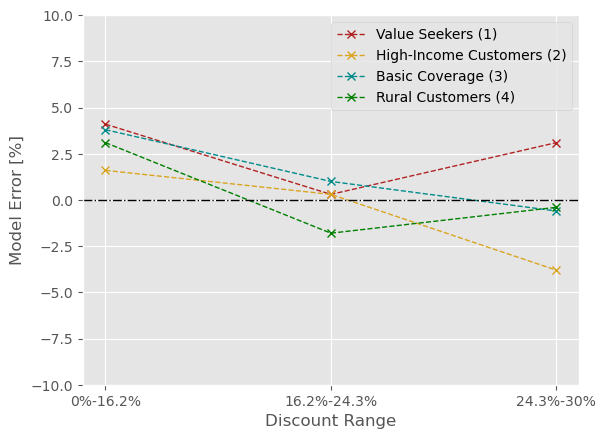

In [31]:
group_1 = [4.1, 0.3, 3.1]
group_2 = [1.6, 0.3, -3.8]
group_3 = [3.8, 1, -0.6]
group_4 = [3.1, -1.8, -0.4]

x = ["0%-16.2%", "16.2%-24.3%", "24.3%-30%"]

fig, ax = plt.subplots()
# ax.plot(x,y)
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

ax.plot(x, group_1, label="Value Seekers (1)", marker="x", linestyle='--', linewidth=1, color="firebrick")
# ax.fill_between(x, (group_1-group_1_ci), (group_1+group_1_ci), alpha=.1, color="firebrick")

ax.plot(x, group_2, label="High-Income Customers (2)", marker="x", linestyle='--', linewidth=1, color="goldenrod")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

ax.plot(x, group_3, label="Basic Coverage (3)", marker="x", linestyle='--', linewidth=1, color="darkcyan")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

ax.plot(x, group_4, label="Rural Customers (4)", marker="x", linestyle='--', linewidth=1, color="green")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

plt.xticks(x)
plt.ylim(-10, 10)
plt.axhline(y=0, color='black', linestyle='-.', linewidth=1)
ax.legend()
plt.xlabel("Discount Range")
plt.ylabel("Model Error [%]")
plt.savefig('../plots/final_errors.png', dpi=200)
plt.show()